In [4]:
%load_ext rpy2.ipython

In [6]:
%R require(ggplot2)

array([1], dtype=int32)

In [3]:
from daal.data_management import AOSNumericTable
from daal.data_management import SOANumericTable
from daal.data_management import BlockDescriptor_Intc
from daal.data_management import BlockDescriptor
from daal.data_management import BlockDescriptor_Float64
from daal.data_management import readOnly
from daal.data_management import readWrite
from daal.data_management import data_feature_utils
from daal.data_management import HomogenNumericTable
from daal.data_management import NumericTableIface
from daal.data_management import MergedNumericTable
from daal.data_management import FileDataSource
from daal.data_management import StringDataSource
from daal.data_management import DataSourceIface
from daal.data_management import packed_mask

from daal.algorithms.linear_regression import training
from daal.algorithms.linear_regression import prediction

import daal.algorithms.normalization.zscore as zscore

from daal import step1Local
from daal import step2Master


import numpy as np

import math

In [40]:
def printNumericTable(data_table, message='', num_printed_rows=0, num_printed_cols=0,
                      interval=10):
    num_rows = data_table.getNumberOfRows()
    num_cols = data_table.getNumberOfColumns()
    layout = data_table.getDataLayout()

    if num_printed_rows != 0:
        num_printed_rows = min(num_rows, num_printed_rows)
    else:
        num_printed_rows = num_rows

    if num_printed_cols != 0:
        num_printed_cols = min(num_cols, num_printed_cols)
    else:
        num_printed_cols = num_cols

    block = BlockDescriptor()
    if isFull(layout) or layout == NumericTableIface.csrArray:
        data_table.getBlockOfRows(0, num_rows, readOnly, block)
        printArray(block.getArray(), num_printed_cols, num_printed_rows,
                   num_cols, message, interval)
        data_table.releaseBlockOfRows(block)
    else:
        packed_table = data_table.getBlockOfRowsAsDouble(0, num_rows)
        if isLower(layout):
            printLowerArray(packed_table, num_printed_rows, message, interval)
        elif isUpper(layout):
            printUpperArray(packed_table, num_printed_cols, num_printed_rows,
                            num_cols, message, interval)
        
def isFull(layout):
    layout_int = int(layout)
    if packed_mask & layout_int:
        return False
    return True


def printArray(array, num_printed_cols, num_printed_rows, num_cols, message,
               interval=10, flt64=True):
    print(message)
    flat_array = array.flatten()
    decimals = '3' if flt64 else '0'
    for i in range(num_printed_rows):
        for j in range(num_printed_cols):
            print("{:<{width}.{dec}f}".format(
                flat_array[i * num_cols + j], width=interval, dec=decimals), end=''
            )
        print()
    print()

    
def getNPArray(data_table):
    num_rows = data_table.getNumberOfRows()
    num_cols = data_table.getNumberOfColumns()
    layout = data_table.getDataLayout()
    np_array = np.ones((num_rows, num_cols), dtype=np.int)
    block = BlockDescriptor()
    data_table.getBlockOfRows(0, num_rows, readOnly, block)
    np_array = block.getArray()
    data_table.releaseBlockOfRows(block)
    return np_array

</div>
    <h1>Introduction to Data Science</h1>
    <h3>Raphael Mendes de Oliveira Cóbe</h3>
    <p>rmcobe@ncc.unesp.br</p>
    <p>Source available on <a href="https://github.com/raphaelmcobe/intel-datascience-workshop">Github</a>

</div>
<div style="width:80%; margin-left:auto; margin-right:auto;">
    <img src=intel_logo.png style="height:170px; float:left;"/>
    <img src=ncc_logo.png style="height:170px; float:right;"/></div>
<div>

# NCC/Unesp

* GridUnesp
    * 256 WorkerNodes
    * Soon to be ~ 85 Tflops
    * Around **70 Projects** from several aereas: Physics, Biology, Chemistry, and so on...
        * Over **300 users**.
    
* Sprace
    * Tier-2 Cern
    * 1PB Raw Data

# Data Science

* Recently open field that put together lots of concepts of other fields, such as:
  * Getting Data (**Open Data!**);
  * Data Analysis;
  * Data Visualization;
  * Data Modelling;
  * **Prediction**;
  * Big Data

# Data Sampling

* With or without Replacement.
* Random, Stratified
* Datasets way too big to fit in memory!

# Data Normalization

# Data Normalization

* adjusting values measured on different scales to a notionally **common scale**
* Outliers detection;
* Z-score, feature scaling, standard score;

# Prediction

# Linear Regression

* Tries to fit a linear function to the data;
* Helps visualizing some data behaviours;

<!--<center><img src="lm.png" style="padding-top:30px;"/></center>-->

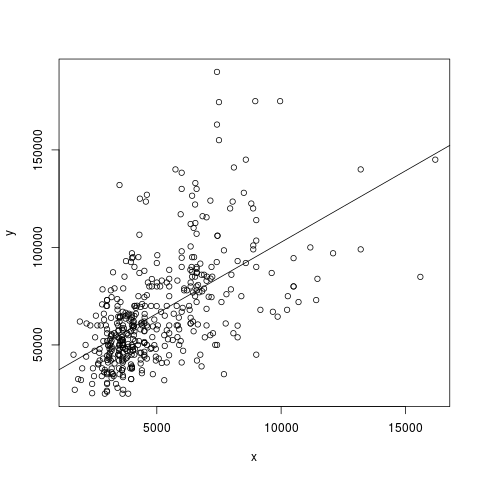

In [15]:
%%R 
dataset <- read.csv('housing-train.csv')
y <- dataset[,1]
x <- dataset[,2]
plot(x,y)
abline(lm(y~x))

# Why use it?

* Questions we may answer:
    * Is there a relationship between house pricing and the house size?

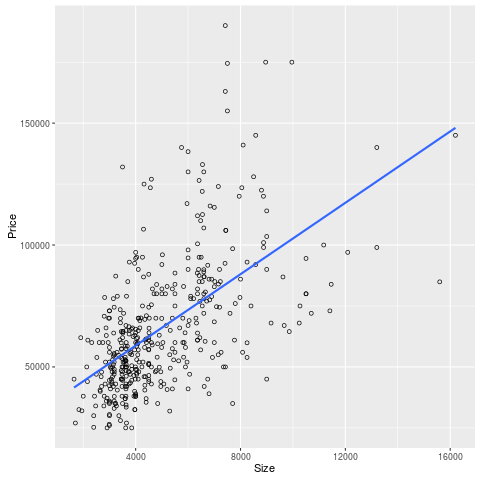

In [20]:
%%R
dataset <- read.csv('./housing-train.csv')
p <- ggplot(dataset, aes(x=dataset[,2], y=dataset[,1])) +
    geom_point(shape=1) + geom_smooth(method=lm, se=FALSE)
print(p + xlab("Size")+ylab("Price"))

# Why use it?

* Questions we may answer:
    * Is there a relationship between house pricing and the number of bedrooms?

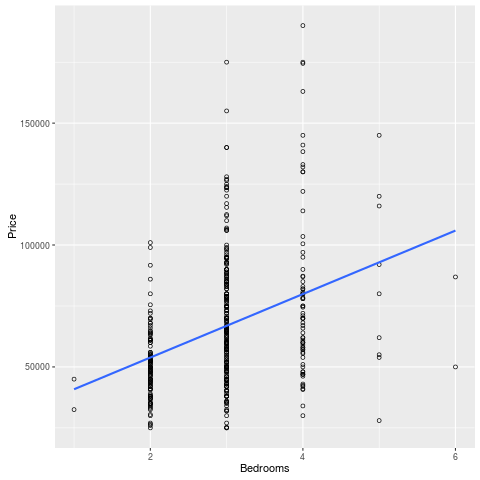

In [21]:
%%R
dataset <- read.csv('./housing-train.csv')
p <- ggplot(dataset, aes(x=dataset[,3], y=dataset[,1])) +
    geom_point(shape=1) + geom_smooth(method=lm, se=FALSE)
print(p + xlab("Bedrooms")+ylab("Price"))

# Regression Problems

* Data set where a **right answer** is given as input to the problem
    * **We know actual prices for houses**
    * Learn what makes the price a certain value from the training data;
    * More right answers based on new training data where we don't know the price already.
* We also call this a regression problem
    * Predict continuous valued output (price)
    * No real discrete delineation 

# The math behind it

* Assume that there is a dependency between variables;
    * More specifically, $y$ depends *linearly* on $x_1, x_2, x_3, ..., x_n$
    * In most real world data, <font color='red'>regression is never Linear</font>;
<!--<center><img src="lm2.png" style="padding-top:30px;"/></center> -->


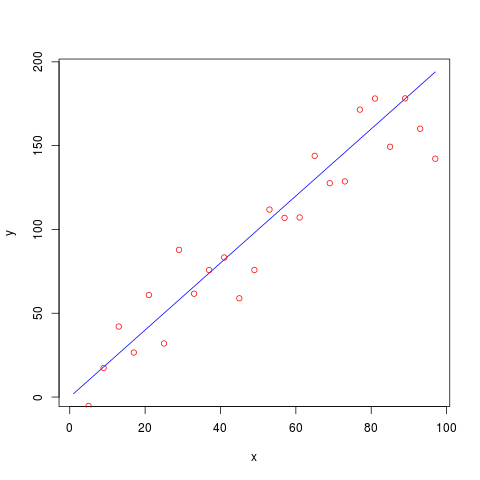

In [39]:
%%R
x <- seq(1, 100, by=4)
y <- x*2
plot(x,y, type="l", col="blue")
z = y+(rnorm(length(y))*20)
points(x,z, col="red")

# The math behind it

* Given samples $(x_i,y_i)$ where $1 \leq i \leq n$
    * Predict $y_{i+1}$ given the new information $x_{i+1}$
* We assume that the dependent variable can be modeled with: $y = \theta_0 + \theta_1x +\epsilon$ where
    * $\theta_0$ is the **intercept**
    * $\theta_1$ is the **slope**
    * $\epsilon$ is the **error**
* Given some estimates $\theta_0$ and $\theta_1$ for the model coeficients, we predict the outcome value $\hat{y}$  using: $\hat{y} = \theta_0+\theta_1x$
* The *ith* residual: $\epsilon_i = y_i - \hat{y}_i$
* A hypothesis takes in some variable;
* Uses parameters determined by a learning system
* Outputs a prediction based on that input

# The math behind it

* If $\theta_1 \geq 0$ then we get a positive slope;
* If $\theta_0 = 1.5$ and $\theta_1 = 0$ then we get straight line parallel with axis X along 1.5;
* The **squared error** is thus: $E=\sum_{i=1}^{m}(y_i - \hat{y}_i)^2$
* We face a **Minimization Problem**

# The math behind it - Normal Equation

* Derivate to get minimum, i.e., $\frac{d}{d\theta_1} = 0$ then solve for $\theta_1$
* Mean Squared Error: $E=\sum_{i=1}^{m}(y_i - \theta_1x_i)^2$
    * Simplify $\theta_0 = 0$<br />
    <center>
$\frac{d}{d\theta_1} = 0$ <br /><br />
</center>
<center>
$-2\sum_{i=1}^{m}x_i(y_i - \theta_1x_i) = 0$<br /><br />
</center>
<center>
$\sum_{i=1}^{m}x_iy_i = \theta_1\sum_{i=1}^{m}x_i^2$<br /><br />
</center>
<center>
$\theta_1 = \frac{\sum_{i=1}^{m}x_iy_i}{\sum_{i=1}^{m}x_i^2}$
</center>

# The math behind it

## Multiple Linear Regression

* We assume that the future data can be modeled with the following: $\hat{y} = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 $ 
* Let's consider now that the $\theta_0, \theta_1, \theta_2, ... \theta_n$ is a vector
* Also, the values of our features $x_1, x_2, x_3, ..., x_n$ are a vector and let's assume that $x_0=1$

$$
\theta=
\begin{bmatrix}
\theta_0\\
\theta_1\\
\theta_2\\
...\\
\theta_n\\
\end{bmatrix}
,\ X=
\begin{bmatrix}
x_0\\
x_1\\
x_2\\
...\\
x_n\\
\end{bmatrix}
$$

# The math behind it

## Multiple Linear Regression (2)

* Thus, in order to estimate $\hat{y}$ in terms of $\theta_0, \theta_1, \theta_2, ..., \theta_n$ and $x_0, x_1, x_2, ..., x_n$ we get:<br /><br />
$$
\hat{y} = \theta_0x_0 + \theta_1x_1+\theta_2x_2+\theta_3x_3+ ...+ \theta_nx_n
$$<br />
then, using a vector product notation we get:<br /><br />
$$
\theta^TX
$$

# The math behind it

## Multiple Linear Regression (3)

* Our **error E** now is a function of the $\theta_0, \theta_1, ... \theta_n$ variables: <br /><br />
$$E(\theta_0,\theta_1,...\theta_n) = \sum_{i=1}^{m} (y_i - \theta_0x_0 + \theta_1x_1+...+ \theta_nx_n)^2$$
<br /><br />
* In order to use the Normal Equation to solve for each $\theta_i$ we have to take the partial derivatives $\frac{\partial}{\partial \theta_i}$

# Error estimation

## Root Mean Square Error
* Differences between values predicted and the values observed;
* Same unit as the observation;<br /><br />
$$\sqrt{\frac{\sum_{i=1}^{m}(\hat{y}_i - y_i)}{m}}$$

# Error estimation

## $R^2$
* Amount of variance explained by the model
* Unitless;<br /><br />
$$SS_{res} = \sum_{i=1}^{m}(\hat{y}_i - y_i)$$<br/><br />
$$SS_{tot} = \sum_{i=1}^{m}(y_i - \bar{y})$$<br/><br />

# Error estimation

## $R^2$
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

# Clustering

# Clustering

* Given a set of data points, group them into a clusters so that:
    * points within each cluster are **similar to each other**
    * points from different clusters are **dissimilar** 
* **Distance Measure**
* Unsupervised learning

# Clustering
* Example: group dogs according to their height and weight

<img src="clustering1.png" />

# Clustering

<img src="clustering2.png" />

# Clustering

<img src="clustering3.png" />

# Clustering
## Can be a very hard task

<img src="clustering4.png" />

# Clustering

* Two intuitive ways of building:
    * Hierarchical: each point starts as a cluster;
        * Fusion of close clusters;
        * How close is close enough?
     * Point assignment:
         * Define an initial number of clusters;
         * Assign points to the closest cluster;

# Euclidean case
* **Centroids**
    * "*Center of mass*" for the data points;
    * Average of points within a cluster;
* Cluster represented by its centroid;
* Distance between 2 clusters = distance between their centroids;


# Non-euclidean
## Distance between points:
* **Clustroids**: Closest point to other poits;

    * Smallest maximum distance to the other points. 
    * Smallest average distance to other points. 
    * Smallest sum of squares of distances to other points.
    * ...

# K-means algorithm

1. Initialize centroids $\mu_1, \mu_2, \mu_3, ...$

<img src="clustering5.png" />

# K-means algorithm

2 . Assign points to the closest clusters;

<img src="clustering6.png" />

# K-means algorithm

3 . Recalculate centroids positions

<img src="clustering7.png" />

# K-means algorithm
4 . Reassign points to closest clusters

<img src="clustering8.png" />

## Repeat until convergence!

# Intel Data Analytics Acceleration Library (DAAL)

# Intel Data Analytics Acceleration Library
* Delivers high application performance across spectrum of Intel®-architecture devices
* Speeds time-to-value through data source and environment integration 
* Reduces application development time via wide selection of pre-optimized advanced analytics algorithms


# What is included?

* Algorithms for:
    * **Pre-processing**, **Transformation**, **Analysis**, **Modeling**.

<center><img src="daal2.png"/></center>

# Data Management

* Data Table
<center><img src="datatable.png" width=400 style="transform:rotate(90deg);"/></center>

# Data Management and Data Structures

* **Heterogeneous Tables** are used when there are multiple data types in a data set (e.g.double, string, etc.) 
    * Structures supported: **Structures of Arrays (SoA)** and **Arrays of Structures (AoS)**. 
* **Homogeneous Tables** are used when the data set has only one type of data. 
    * Two types of homogeneous tables: **dense** and **sparse**. 

# Data Management and Data Structures

* **Matrices** are used when the application requires matrix algebra type workloads
    * Three kinds of matrices supported: **dense matrix**, **packed symmetric matrix**, and **packed triangular matri-ces**. 




# AOS vs SOA

<center><img src="aos.png" style="height:220px;"/></center>
<center><img src="soa.png" style="height:320px;"/></center>

# Why Use it?

* Modes: 
    * **Batch**: the only compute method of a particular algorithm class is used; 
    * **Online**: this computation mode assumes that the data arrives in blocks;
        * `compute()` method each time new input becomes available.
        * When the last block of data arrives, call the `finalizeCompute()` method to produce final results;

# Why Use it?
* Modes:
    * **Distributed**: data sets distributed across several devices;
        * Assumes that the data set is split in *nblocks* blocks across computation nodes.
        * define the computation step for an algorithm; 

# Why Use it? Distributed!

* Provide the `computeStep` value to the constructor during initialization of the algorithm;
* Use the `compute()` method on each computation node (partial results)
* Provide the computeStep value to the constructor during initialization of the algorithm;
* Use the `compute()` method on each computation node (partial results)

# Distributed processing

<center><img src="distributed.png" style="padding-top:40px; height:650px;"/></center>

# Distributed processing

<center><img src="distributed2.png" style="padding-top:40px; height:650px;"/></center>


# What about Spark?

* Almost the same set of Algorithms.

<center><img src="daal_vs_spark.png"/></center>

# Any questions?

# We are hiring!

* **Data science/HPC** specialists;
* **Machine Learning** specialists;
* Sysadmin to work on a **Software Defined Network** project;